# Прогнозирование оттока клиентов банка

### Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. В нашем распоряжении исторические данные о поведении клиентов и расторжении договоров с банком.

**Цель проекта** – спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Требуется построить модель с предельно большим значением F1-меры, дополнительно сравнивая последнее со значением AUC-ROC.

**Задачи:** 

- загрузить и подготовить данные,
- исследовать баланс классов, обучить модель без учёта дисбаланса,
- улучшить качество модели, учитывая дисбаланс классов; обучить разные модели и найти лучшую,
- провести финальное тестирование.

**Описание данных**

**Признаки**

* `RowNumber` — индекс строки в данных,
* `CustomerId` — уникальный идентификатор клиента,
* `Surname` — фамилия,
* `CreditScore` — кредитный рейтинг,
* `Geography` — страна проживания,
* `Gender` — пол,
* `Age` — возраст,
* `Tenure` — сколько лет человек является клиентом банка,
* `Balance` — баланс на счёте,
* `NumOfProducts` — количество продуктов банка, используемых клиентом,
* `HasCrCard` — наличие кредитной карты,
* `IsActiveMember` — активность клиента,
* `EstimatedSalary` — предполагаемая зарплата.

**Целевой признак**

* `Exited` — факт ухода клиента.

### Подготовка данных

#### Изучение и предобработка данных

In [2]:
# импортирование необходимых библиотек
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [3]:
# загрузка данных
try:
    data = pd.read_csv('/datasets/Churn.csv')
except:
    data = pd.read_csv('E:/ЯП/Курс_спец_Data_Science/7_Обучение с учителем/Churn.csv')

In [5]:
# вывод первых 5 строк датафрейма
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Замечаем, что необходимо привести названия колонок к стилю snake_case. 

In [6]:
# список названий колонок
columns = data.columns.values.tolist()

In [7]:
# приведение названий колонок к регистру snake_case
columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', x).lower() for x in columns]

In [8]:
# check
columns

['row_number',
 'customer_id',
 'surname',
 'credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited']

In [9]:
# присваивание столбцам отформатированных названий
data.columns = columns

Посмотрим на размер датафрейма, тип значений и наличие пропущенных значений в колонках:

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Исследуемый датафрейм состоит из 10000 строк и 14 столбцов. В колонке `tenure` имеются пропущенные значения. Типы переменных в колонках соответствуют описанию данных за исключением столбца `tenure` - значения должны быть целочисленными.

In [11]:
# проверка на явные дубликаты
data.duplicated().sum()

0

In [12]:
# проверка на дубликаты в колонке 'customer_id'
data.customer_id.duplicated().sum()

0

In [13]:
# процент пропусков в колонке `tenure`
data.tenure.isna().sum() / 100

9.09

In [14]:
# список уникальных значений в колонке `tenure`
data.tenure.unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [15]:
# уникальные значения в столбце в порядке убывания частоты их упоминаний
data.tenure.value_counts(normalize=True).to_frame()

,tenure
1.0,0.104719
2.0,0.104499
8.0,0.102629
3.0,0.102079
5.0,0.101969
7.0,0.101749
4.0,0.097349
9.0,0.097019
6.0,0.096909
10.0,0.049060


In [16]:
# коэффициент корреляции между 'tenure' и 'exited'
data['tenure'].corr(data['exited'])

-0.016761481514933837

Удалять 9 % записей из датасета из-за наличия пропусков в колонке `tenure` нецелесообразно. Корреляция между значениями в `tenure` и целевым признаком `exited` отсутсвует, скорее всего важность этой переменной для предсказания будет низкой. Заполним пропуски медианным значением.

In [17]:
# медианное значение в колонке 'tenure'
tenure_median = data['tenure'].median()

In [18]:
# замена пропусков на медиану 
data['tenure'].fillna(tenure_median, inplace=True)

In [19]:
# количество пропусков в колонке `tenure`
data.tenure.isna().sum()

0

In [20]:
# преобразование типа данных в целочисленный
data['tenure'] = data['tenure'].astype('int64')

In [21]:
# список основных статистик для колонок с количественными данными
data[['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']].describe().T.style.format("{:.1f}")

,count,mean,std,min,25%,50%,75%,max
credit_score,10000.0,650.5,96.7,350.0,584.0,652.0,718.0,850.0
age,10000.0,38.9,10.5,18.0,32.0,37.0,44.0,92.0
tenure,10000.0,5.0,2.8,0.0,3.0,5.0,7.0,10.0
balance,10000.0,76485.9,62397.4,0.0,0.0,97198.5,127644.2,250898.1
estimated_salary,10000.0,100090.2,57510.5,11.6,51002.1,100193.9,149388.2,199992.5


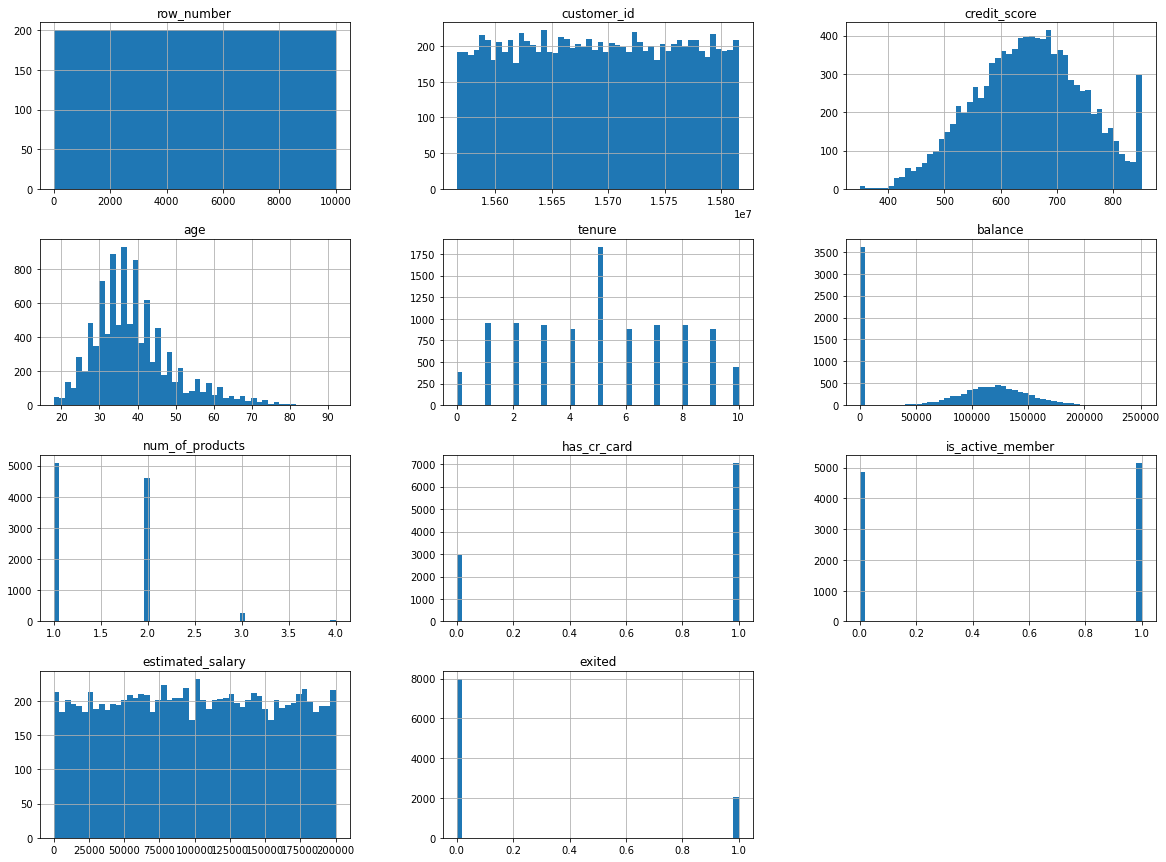

In [22]:
# общая гистограмма для всех столбцов таблицы
data.hist(figsize=(20, 15), bins=50);

Из приведенных выше таблицы и гистограмм не наблюдается аномалий и существенных выбросов в данных. Также видим, что:

* большинству клиентов банка от 30 до 40 лет,
* клиенты чаще пользуются одним или двумя продуктами банка, 
* большинство имеет кредитную карту и не имеет баланса на счете,
* активных клиентов незначительно больше чем неактивных,
* оставшихся клиентов почти в 4 раза больше чем ушедших.

In [23]:
# уникальные значения в столбце 'exited' в порядке убывания частоты их упоминаний
data.exited.value_counts(normalize=True).to_frame().style.format("{:.2f}")

,exited
0,0.80
1,0.20


Наблюдается дисбаланс классов в целевом признаке.

In [24]:
# уникальные значения в столбце 'gender' в порядке убывания частоты их упоминаний
data.gender.value_counts(normalize=True).to_frame().style.format("{:.2f}")

,gender
Male,0.55
Female,0.45


Клиентов мужского пола примерно на 10 % больше чем женского.

In [25]:
# уникальные значения в столбце 'geography' в порядке убывания частоты их упоминаний
data.geography.value_counts(normalize=True).to_frame().style.format("{:.2f}")

,geography
France,0.50
Germany,0.25
Spain,0.25


Около половины клиентов проживают во Франции и по четверти - в Германии и Испании.

#### Подготовка данных для машинного обучения

Информация, содержащаяся в колонках `row_number`, `customer_id`, и `surname`, не несет в себе ценности и не потребуется для последующего обучения моделей, поэтому удалим эти колонки.

In [26]:
# удаление столбцов из исходного датафрейма
data.drop(['row_number', 'customer_id', 'surname'], axis=1, inplace=True)

In [27]:
# check
data.head(3)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


##### Прямое кодирование

В датафрейме присутсвуют категориальные признаки - `geography` и `gender`. С помощью техники прямого кодирования (One-Hot Encoding) преобразуем их в численные признаки.

In [28]:
# прямое кодирование
data = pd.get_dummies(data, drop_first=True)

In [29]:
# check
data.head(3)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0


In [30]:
# переименовывание названий колонок
data.rename(columns={'geography_Germany': 'is_germany', 'geography_Spain': 'is_spain', 'gender_Male': 'is_male'},
            inplace=True)

In [31]:
# check
data.head(3)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,is_germany,is_spain,is_male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0


##### Разделение исходных данных на выборки

Сохраним в отдельные переменные признаки и целевой признак.

In [32]:
# признаки
features = data.drop(['exited'], axis=1)
# целевой признак
target = data['exited']

Разобьем данные на 3 части - обучающую, валидационную и тестовую выборки, в соотношении 3:1:1.

Пропорцию классов при разделении будем задавать в соответствии с распределением по классам в целевом признаке `target`.

In [33]:
# выделение обучающей выборки (60%) и валидационной с тестовой (40%)
features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                              target, 
                                                                              test_size=0.4,
                                                                              random_state=12345,
                                                                              stratify=target)

In [34]:
# повтороное деление валидационной выборки пополам
# выделение валидационной выборки (20%) и тестовой (20%)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
                                                                            target_valid,
                                                                            test_size=0.5,
                                                                            random_state=12345,
                                                                            stratify=target_valid)

In [35]:
print(f'Количество строк в target по классам: {np.bincount(target)}, размер target: {target.shape[0]}')
print(f'Количество строк в target_train по классам: {np.bincount(target_train)}, размер target_train: {target_train.shape[0]}')
print(f'Количество строк в target_valid по классам: {np.bincount(target_valid)}, размер target_valid: {target_valid.shape[0]}')
print(f'Количество строк в target_test по классам: {np.bincount(target_test)}, размер target_test: {target_test.shape[0]}')

Количество строк в target по классам: [7963 2037], размер target: 10000
Количество строк в target_train по классам: [4778 1222], размер target_train: 6000
Количество строк в target_valid по классам: [1592  408], размер target_valid: 2000
Количество строк в target_test по классам: [1593  407], размер target_test: 2000


##### Масштабирование количественных признаков

Значения количественных признаков и их разбросы значительно отличаются друг от друга, поэтому приведем эти признаки к одному масштабу. Воспользуемся методом стандартизации данных.

In [36]:
# количественные признаки, требующие масштабирования 
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

In [37]:
# объект структуры для стандартизации данных
scaler = StandardScaler()

In [38]:
# настройка объекта scaler на обучающих данных
scaler.fit(features_train[numeric])

StandardScaler()

In [39]:
# масштабирование количественных признаков обучающей, валидационной и тестовой выборок
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [40]:
# check
features_train.head(3)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,is_germany,is_spain,is_male
2837,-1.040434,0.953312,0.360600,0.774657,-0.914708,0,1,-0.119110,1,0,0
9925,0.454006,-0.095244,-0.002786,1.910540,-0.914708,1,1,-0.258658,0,0,0
8746,0.103585,-0.476537,1.087371,0.481608,0.820981,0,1,1.422836,0,0,1


In [41]:
# check
features_valid.head(3)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,is_germany,is_spain,is_male
6612,-1.524838,2.383160,-0.729557,1.011655,-0.914708,0,1,0.010275,0,0,0
519,0.587990,1.811221,0.360600,0.213192,-0.914708,0,1,0.453089,0,0,1
1609,-0.318980,-0.381213,1.087371,0.893896,-0.914708,1,0,-0.603508,0,0,0


In [42]:
# check
features_test.head(3)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,is_germany,is_spain,is_male
657,-0.504497,1.429928,-1.456328,0.873883,0.820981,1,1,1.725255,1,0,0
2083,-1.195031,-1.429769,-1.456328,-1.219673,-0.914708,1,1,1.203665,0,0,1
3234,-1.267176,0.762665,-1.456328,-1.219673,-0.914708,1,0,-1.374743,0,0,1


#### Вывод

В этой части проекта:

* проведено ознакомление с исходными данными,

* переведены названия столбцов к регистру snake_case,
* обработаны пропуски и изменены типы данных, где это необходимо,
* дубликаты и аномальные значения не обнаружены,
* удалены колонки неважные для предсказания,
* категориальные признаки преобразованы в численные,
* данные разделены на обучающую, валидационную и тестовую выборки с оптимальной стратификацией классов,
* произведено масштабирование количественных признаков с помощью метода стандартизации данных,
* обнаружен дисбаланс классов целевого признака 1:4, поэтому метрика accuracy для оценки качества моделей не подходит.

Данные готовы для обучения, проверки и тестирования моделей.

### Исследование задачи

Сначала проведем обучение моделей без учета дисбаланса классов, затем учтем его и сравним качество получившихся моделей.

Рассмотрим модели логистическая регрессия, решающее дерево и случайный лес. Меняя гиперпараметры, оценим качество этих моделей на валидационной выборке с помощью метрики F1-мера. Дополнительно будем измерять метрику AUC-ROC.

#### Логистическая регрессия

In [149]:
%%time

best_model_lr = None
best_f1_score_lr = 0
# определение списка, содержащего значения обратной силы регуляризации
C_1 = np.linspace(0.0001, 1, 500)
C_2 = np.linspace(2, 1000, 500)
C_values = np.concatenate((C_1, C_2))

for solv in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    for c in C_values:
        # получение структуры данных для классификации логистической регрессией
        model_lr = LogisticRegression(solver=solv,
                                      C=c,
                                      max_iter=1000,                
                                      random_state=12345,
                                      n_jobs=-1)
        # обучение модели на тренировочной выборке
        model_lr.fit(features_train, target_train)
        # передсказания модели на валидационной выборке
        predicted_valid = model_lr.predict(features_valid)
        # значение F1-мера модели на валидационной выборке
        f1_score_lr = f1_score(target_valid, predicted_valid)
        if f1_score_lr > best_f1_score_lr:
            # наилучшее значение метрики F1-мера на валидационных данных
            best_f1_score_lr = f1_score_lr
            # наилучшая модель согласно метрике F1-мера
            best_model_lr = model_lr

print(f'F1-мера наилучшей модели на валидационной выборке:{best_f1_score_lr: .3f}')

F1-мера наилучшей модели на валидационной выборке: 0.311
CPU times: total: 57.4 s
Wall time: 1min 19s


In [150]:
# гиперпараметры модели с наилучшим значением F1-мера (не указанные в '()' равны значениям по умолчанию)
best_model_lr

LogisticRegression(C=2.0, max_iter=1000, n_jobs=-1, random_state=12345,
                   solver='newton-cg')

In [148]:
# значение метрики AUC-ROC при наилучшем значении метрики F1-мера на валидационных данных
print(f'{roc_auc_score(target_valid, best_model_lr.predict_proba(features_valid)[:, 1]): .3f}')

 0.787


#### Решающее дерево

In [153]:
%%time

best_model_dt = None
best_f1_score_dt = 0
for crit in ['gini', 'entropy']:
    for depth in range(1, 21):
        for samples_split in range(2, 203, 10):
            for samples_leaf in range(1, 202, 10):
                # получение структуры данных для классификации деревом решений
                model_dt = DecisionTreeClassifier(criterion=crit, 
                                                  max_depth=depth,
                                                  min_samples_split=samples_split,
                                                  min_samples_leaf=samples_leaf,
                                                  random_state=12345)
                # обучение модели на тренировочной выборке
                model_dt.fit(features_train, target_train)
                # передсказания модели на валидационной выборке
                predicted_valid = model_dt.predict(features_valid)
                # значение F1-мера модели на валидационной выборке
                f1_score_dt = f1_score(target_valid, predicted_valid)
                if f1_score_dt > best_f1_score_dt:
                    # наилучшее значение метрики F1-мера на валидационных данных
                    best_f1_score_dt = f1_score_dt
                    # наилучшая модель согласно метрике F1-мера
                    best_model_dt = model_dt

print(f'F1-мера наилучшей модели на валидационной выборке:{best_f1_score_dt: .3f}')

F1-мера наилучшей модели на валидационной выборке: 0.618
CPU times: total: 3min 31s
Wall time: 3min 31s


In [154]:
# гиперпараметры модели с наилучшим значением F1-мера (не указанные в '()' равны значениям по умолчанию)
best_model_dt

DecisionTreeClassifier(max_depth=10, min_samples_split=112, random_state=12345)

In [156]:
# значение метрики AUC-ROC при наилучшем значении метрики F1-мера на валидационных данных
print(f'{roc_auc_score(target_valid, best_model_dt.predict_proba(features_valid)[:, 1]): .3f}')

 0.847


#### Случайный лес

In [212]:
%%time

best_model_rf = None
best_f1_score_rf = 0
for crit in ['gini', 'entropy']:
    for est in range(40, 171, 20):
        for depth in range(1, 21):
            for samples_split in range(2, 203, 40):
                for samples_leaf in range(1, 202, 40):
                    # получение структуры данных для классификации случайным лесом
                    model_rf = RandomForestClassifier(n_estimators=est,
                                                      criterion=crit, 
                                                      max_depth=depth,
                                                      min_samples_split=samples_split,
                                                      min_samples_leaf=samples_leaf,
                                                      random_state=12345,
                                                      n_jobs=-1)
                    # обучение модели на тренировочной выборке
                    model_rf.fit(features_train, target_train)
                    # передсказания модели на валидационной выборке
                    predicted_valid = model_rf.predict(features_valid)
                    # значение F1-мера модели на валидационной выборке
                    f1_score_rf = f1_score(target_valid, predicted_valid)
                    if f1_score_rf > best_f1_score_rf:
                        # наилучшее значение метрики F1-мера на валидационных данных
                        best_f1_score_rf = f1_score_rf
                        # наилучшая модель согласно метрике F1-мера
                        best_model_rf = model_rf

print(f'F1-мера наилучшей модели на валидационной выборке:{best_f1_score_rf: .3f}')

F1-мера наилучшей модели на валидационной выборке: 0.628
CPU times: total: 59min 30s
Wall time: 23min 26s


In [213]:
# гиперпараметры модели с наилучшим значением F1-мера (не указанные в '()' равны значениям по умолчанию)
best_model_rf

RandomForestClassifier(max_depth=15, n_estimators=60, n_jobs=-1,
                       random_state=12345)

In [215]:
# значение метрики AUC-ROC при наилучшем значении метрики F1-мера на валидационных данных
print(f'{roc_auc_score(target_valid, best_model_rf.predict_proba(features_valid)[:, 1]): .3f}')

 0.864


#### Вывод

В ходе исследования варьированием гиперпараметров были получены модели, обученные различными алгоритмами на несбалансированной тренировочной выборке, с наилучшим значением метрики качества F1-мера на валидационной выборке. Также рассчитывалась метрика AUC-ROC. В результате для модели:

* логистической регрессии: F1-мера = 0.311, AUC-ROC = 0.787,
* дерева решений: F1-мера = 0.618, AUC-ROC = 0.847,
* случайного леса: F1-мера = 0.628, AUC-ROC = 0.864.

Таким образом, наилучшей моделью согласно метрике F1-мера в этом случае оказалась модель, обученная случайным лесом. Подобранные гиперпараметры, обеспечивающие F1-мера 0.628 – max_depth=15, n_estimators=60, остальные гиперпараметры равны значениям по умолчанию. В этом случае метрика AUC-ROC также максимальна - 0.864.

### Борьба с дисбалансом

#### RandomUnderSampler

Эта техника случайно удаляет некоторое число примеров мажоритарного класса, что позволяет добиться баланса классов.

In [286]:
# создание экземпляра класса RandomUnderSampler
rus = RandomUnderSampler(random_state=12345)
# устранение дисбаланса классов в тренировочных выборках
features_resampled, target_resampled = rus.fit_resample(features_train, target_train)

##### Логистическая регрессия

In [167]:
%%time

best_model_lr_rus = None
best_f1_score_lr_rus = 0

for solv in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    for c in C_values:
        # получение структуры данных для классификации логистической регрессией
        model_lr = LogisticRegression(solver=solv,
                                      C=c,
                                      max_iter=1000,                
                                      random_state=12345,
                                      n_jobs=-1)
        # обучение модели на тренировочной выборке
        model_lr.fit(features_resampled, target_resampled)
        # передсказания модели на валидационной выборке
        predicted_valid = model_lr.predict(features_valid)
        # значение F1-мера модели на валидационной выборке
        f1_score_lr = f1_score(target_valid, predicted_valid)
        if f1_score_lr > best_f1_score_lr_rus:
            # наилучшее значение метрики F1-мера на валидационных данных
            best_f1_score_lr_rus = f1_score_lr
            # наилучшая модель согласно метрике F1-мера
            best_model_lr_rus = model_lr

print(f'F1-мера наилучшей модели на валидационной выборке:{best_f1_score_lr_rus: .3f}')

F1-мера наилучшей модели на валидационной выборке: 0.532
CPU times: total: 36 s
Wall time: 49.8 s


In [168]:
# гиперпараметры модели с наилучшим значением F1-мера (не указанные в '()' равны значениям по умолчанию)
best_model_lr_rus

LogisticRegression(C=0.004107615230460922, max_iter=1000, n_jobs=-1,
                   random_state=12345, solver='liblinear')

In [170]:
# значение метрики AUC-ROC при наилучшем значении метрики F1-мера на валидационных данных
print(f'{roc_auc_score(target_valid, best_model_lr_rus.predict_proba(features_valid)[:, 1]): .3f}')

 0.791


##### Решающее дерево

In [173]:
%%time

best_model_dt_rus = None
best_f1_score_dt_rus = 0
for crit in ['gini', 'entropy']:
    for depth in range(1, 21):
        for samples_split in range(2, 203, 10):
            for samples_leaf in range(1, 202, 10):
                # получение структуры данных для классификации деревом решений
                model_dt = DecisionTreeClassifier(criterion=crit, 
                                                  max_depth=depth,
                                                  min_samples_split=samples_split,
                                                  min_samples_leaf=samples_leaf,
                                                  random_state=12345)
                # обучение модели на тренировочной выборке
                model_dt.fit(features_resampled, target_resampled)
                # передсказания модели на валидационной выборке
                predicted_valid = model_dt.predict(features_valid)
                # значение F1-мера модели на валидационной выборке
                f1_score_dt = f1_score(target_valid, predicted_valid)
                if f1_score_dt > best_f1_score_dt_rus:
                    # наилучшее значение метрики F1-мера на валидационных данных
                    best_f1_score_dt_rus = f1_score_dt
                    # наилучшая модель согласно метрике F1-мера
                    best_model_dt_rus = model_dt

print(f'F1-мера наилучшей модели на валидационной выборке:{best_f1_score_dt_rus: .3f}')

F1-мера наилучшей модели на валидационной выборке: 0.608
CPU times: total: 1min 32s
Wall time: 1min 32s


In [174]:
# гиперпараметры модели с наилучшим значением F1-мера (не указанные в '()' равны значениям по умолчанию)
best_model_dt_rus

DecisionTreeClassifier(max_depth=9, min_samples_split=82, random_state=12345)

In [176]:
# значение метрики AUC-ROC при наилучшем значении метрики F1-мера на валидационных данных
print(f'{roc_auc_score(target_valid, best_model_dt_rus.predict_proba(features_valid)[:, 1]): .3f}')

 0.845


##### Случайный лес

In [217]:
%%time

best_model_rf_rus = None
best_f1_score_rf_rus = 0
for crit in ['gini', 'entropy']:
    for est in range(40, 171, 20):
        for depth in range(1, 21):
            for samples_split in range(2, 203, 40):
                for samples_leaf in range(1, 202, 40):
                    # получение структуры данных для классификации случайным лесом
                    model_rf = RandomForestClassifier(n_estimators=est,
                                                      criterion=crit, 
                                                      max_depth=depth,
                                                      min_samples_split=samples_split,
                                                      min_samples_leaf=samples_leaf,
                                                      random_state=12345,
                                                      n_jobs=-1)
                    # обучение модели на тренировочной выборке
                    model_rf.fit(features_resampled, target_resampled)
                    # передсказания модели на валидационной выборке
                    predicted_valid = model_rf.predict(features_valid)
                    # значение F1-мера модели на валидационной выборке
                    f1_score_rf = f1_score(target_valid, predicted_valid)
                    if f1_score_rf > best_f1_score_rf_rus:
                        # наилучшее значение метрики F1-мера на валидационных данных
                        best_f1_score_rf_rus = f1_score_rf
                        # наилучшая модель согласно метрике F1-мера
                        best_model_rf_rus = model_rf

print(f'F1-мера наилучшей модели на валидационной выборке:{best_f1_score_rf_rus: .3f}')

F1-мера наилучшей модели на валидационной выборке: 0.636
CPU times: total: 32min 54s
Wall time: 20min 43s


In [218]:
# гиперпараметры модели с наилучшим значением F1-мера (не указанные в '()' равны значениям по умолчанию)
best_model_rf_rus

RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=160,
                       n_jobs=-1, random_state=12345)

In [220]:
# значение метрики AUC-ROC при наилучшем значении метрики F1-мера на валидационных данных
print(f'{roc_auc_score(target_valid, best_model_rf_rus.predict_proba(features_valid)[:, 1]): .3f}')

 0.870


#### SMOTE (Synthetic Minority Over-sampling Technique)

Эта техника увеличивает число примеров миноритарного класса.

In [44]:
# устранение дисбаланса классов в тренировочных выборках с помощью SMOTE
features_resampled_smote, target_resampled_smote = SMOTE(random_state=12345).fit_resample(features_train, target_train)

##### Логистическая регрессия

In [180]:
%%time

best_model_lr_smote = None
best_f1_score_lr_smote = 0

for solv in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    for c in C_values:
        # получение структуры данных для классификации логистической регрессией
        model_lr = LogisticRegression(solver=solv,
                                      C=c,
                                      max_iter=1000,                
                                      random_state=12345,
                                      n_jobs=-1)
        # обучение модели на тренировочной выборке
        model_lr.fit(features_resampled_smote, target_resampled_smote)
        # передсказания модели на валидационной выборке
        predicted_valid = model_lr.predict(features_valid)
        # значение F1-мера модели на валидационной выборке
        f1_score_lr = f1_score(target_valid, predicted_valid)
        if f1_score_lr > best_f1_score_lr_smote:
            # наилучшее значение метрики F1-мера на валидационных данных
            best_f1_score_lr_smote = f1_score_lr
            # наилучшая модель согласно метрике F1-мера
            best_model_lr_smote = model_lr

print(f'F1-мера наилучшей модели на валидационной выборке:{best_f1_score_lr_smote: .3f}')

F1-мера наилучшей модели на валидационной выборке: 0.527
CPU times: total: 1min 20s
Wall time: 1min 52s


In [181]:
# гиперпараметры модели с наилучшим значением F1-мера (не указанные в '()' равны значениям по умолчанию)
best_model_lr_smote

LogisticRegression(C=0.002103807615230461, max_iter=1000, n_jobs=-1,
                   random_state=12345, solver='liblinear')

In [183]:
# значение метрики AUC-ROC при наилучшем значении метрики F1-мера на валидационных данных
print(f'{roc_auc_score(target_valid, best_model_lr_smote.predict_proba(features_valid)[:, 1]): .3f}')

 0.790


##### Решающее дерево

In [184]:
%%time

best_model_dt_smote = None
best_f1_score_dt_smote = 0
for crit in ['gini', 'entropy']:
    for depth in range(1, 21):
        for samples_split in range(2, 203, 10):
            for samples_leaf in range(1, 202, 10):
                # получение структуры данных для классификации деревом решений
                model_dt = DecisionTreeClassifier(criterion=crit, 
                                                  max_depth=depth,
                                                  min_samples_split=samples_split,
                                                  min_samples_leaf=samples_leaf,
                                                  random_state=12345)
                # обучение модели на тренировочной выборке
                model_dt.fit(features_resampled_smote, target_resampled_smote)
                # передсказания модели на валидационной выборке
                predicted_valid = model_dt.predict(features_valid)
                # значение F1-мера модели на валидационной выборке
                f1_score_dt = f1_score(target_valid, predicted_valid)
                if f1_score_dt > best_f1_score_dt_smote:
                    # наилучшее значение метрики F1-мера на валидационных данных
                    best_f1_score_dt_smote = f1_score_dt
                    # наилучшая модель согласно метрике F1-мера
                    best_model_dt_smote = model_dt

print(f'F1-мера наилучшей модели на валидационной выборке:{best_f1_score_dt_smote: .3f}')

F1-мера наилучшей модели на валидационной выборке: 0.601
CPU times: total: 6min 34s
Wall time: 6min 34s


In [185]:
# гиперпараметры модели с наилучшим значением F1-мера (не указанные в '()' равны значениям по умолчанию)
best_model_dt_smote

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=71,
                       min_samples_split=192, random_state=12345)

In [187]:
# значение метрики AUC-ROC при наилучшем значении метрики F1-мера на валидационных данных
print(f'{roc_auc_score(target_valid, best_model_dt_smote.predict_proba(features_valid)[:, 1]): .3f}')

 0.847


##### Случайный лес

In [45]:
%%time

best_model_rf_smote = None
best_f1_score_rf_smote = 0
for crit in ['gini', 'entropy']:
    for est in range(40, 171, 20):
        for depth in range(1, 21):
            for samples_split in range(2, 203, 40):
                for samples_leaf in range(1, 202, 40):
                    # получение структуры данных для классификации случайным лесом
                    model_rf = RandomForestClassifier(n_estimators=est,
                                                      criterion=crit, 
                                                      max_depth=depth,
                                                      min_samples_split=samples_split,
                                                      min_samples_leaf=samples_leaf,
                                                      random_state=12345,
                                                      n_jobs=-1)
                    # обучение модели на тренировочной выборке
                    model_rf.fit(features_resampled_smote, target_resampled_smote)
                    # передсказания модели на валидационной выборке
                    predicted_valid = model_rf.predict(features_valid)
                    # значение F1-мера модели на валидационной выборке
                    f1_score_rf = f1_score(target_valid, predicted_valid)
                    if f1_score_rf > best_f1_score_rf_smote:
                        # наилучшее значение метрики F1-мера на валидационных данных
                        best_f1_score_rf_smote = f1_score_rf
                        # наилучшая модель согласно метрике F1-мера
                        best_model_rf_smote = model_rf

print(f'F1-мера наилучшей модели на валидационной выборке:{best_f1_score_rf_smote: .3f}')

F1-мера наилучшей модели на валидационной выборке: 0.641
CPU times: total: 1h 45min 49s
Wall time: 26min 16s


In [46]:
# гиперпараметры модели с наилучшим значением F1-мера (не указанные в '()' равны значениям по умолчанию)
best_model_rf_smote

RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_split=82,
                       n_jobs=-1, random_state=12345)

In [47]:
# значение метрики AUC-ROC при наилучшем значении метрики F1-мера на валидационных данных
print(f'{roc_auc_score(target_valid, best_model_rf_smote.predict_proba(features_valid)[:, 1]): .3f}')

 0.869


#### Вывод

Результаты обучения моделей различными алгоритмами на сбалансированной техникой RandomUnderSampler тренировочной выборке с наилучшим значением метрики качества F1-мера на валидационных данных:

* логистической регрессии: F1-мера = 0.532, AUC-ROC = 0.791,
* дерева решений: F1-мера = 0.608, AUC-ROC = 0.845,
* случайного леса: F1-мера = 0.636, AUC-ROC = 0.870.

Результаты обучения моделей различными алгоритмами на сбалансированной техникой SMOTE тренировочной выборке с наилучшим значением метрики качества F1-мера на валидационных данных:

* модель логистической регрессии: F1-мера = 0.527, AUC-ROC = 0.790,
* модель дерева решений: F1-мера = 0.601, AUC-ROC = 0.847,
* модель случайного леса: F1-мера = 0.641, AUC-ROC = 0.869.

Видно, что, согласно метрике F1-мера, учет дисбаланса классов привел к улучшению качества модели для логистической регрессии (без учета дисбаланса F1-мера = 0.311) и случайного леса (без учета дисбаланса F1-мера = 0.628). В случае дерева решений качесто снизилось - без учета дисбаланса F1-мера = 0.618.

Во всех случаях значение AUC-ROC больше 0.5, следовательно, все модели адекватны, их качество лучше чем у случайной модели. 

Наилучшей из всех полученных моделей оказалась модель, обученная случайным лесом на сбалансированных данных техникой SMOTE. Подобранные гиперпараметры, обеспечивающие F1-мера 0.641 – criterion='entropy', max_depth=15, min_samples_split=82, остальные гиперпараметры равны значениям по умолчанию.

### Тестирование модели

Проверим качество модели, получившей лучший результат значения метрики F1-мера на валиданионных данных, на тестовой выборке.

In [48]:
print(f'F1-мера:{f1_score(target_test, best_model_rf_smote.predict(features_test)): .3f}')

F1-мера: 0.604


In [69]:
# значение метрики AUC-ROC
auc_roc = roc_auc_score(target_test, best_model_rf_smote.predict_proba(features_test)[:, 1])
print(f'AUC-ROC:{auc_roc: .3f}')

AUC-ROC: 0.854


Дополнительно результат работы алгоритма на тестовой выборке визуализируем с помощью ROC-кривой.

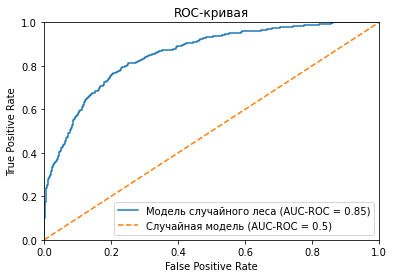

In [74]:
# значения FPR, TPR и рассмотренные пороги
fpr, tpr, thresholds = roc_curve(target_test, best_model_rf_smote.predict_proba(features_test)[:, 1])

plt.figure()

# построение графика ROC-кривой модели случайного леса
plt.plot(fpr, tpr, label='Модель случайного леса (AUC-ROC = %0.2f)' % auc_roc)
# построение графика ROC-кривой случайной модели
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель (AUC-ROC = 0.5)')

# границы осей 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# подписи осей
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# заголовок графика
plt.title('ROC-кривая')
# расположение легенды
plt.legend(loc='lower right');

#### Вывод

Таким образом, построенная модель с максимальной метрикой F1-мера на валидационной выборке (0.641) на тестовой выборке показала результат 0.604.

### Общий вывод

Было проведено исследование, позволившее построить модель для задачи классификации, которая прогнозирует, уйдёт клиент из банка в ближайшее время или нет. Входные данные – данные о поведении клиентов и расторжении договоров с банком.

При изучении файла с данными не выявлено аномалий и существенных выбросов в признаках. В колонке `tenure` были обработаны пропущенные значения и изменен тип данных. Из датасета были удалены три признака, не несущие информацию для предсказания. Имеющиеся категориальные признаки были обработаны техникой прямого кодирования. 

Данные были разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 с учетом дисбаланса классов в целевом признаке. Размеры получившихся выборок следующие: обучающей – 6000 строк, валидационной и тестовой – по 2000 строк соответственно. Количественные признаки были отмасштабированы методом стандартизации данных.

Был обнаружен дисбаланс классов 1:4, модели обучались и с учетом и без учета дисбаланса. Для борьбы с дисбалансом использовались две техники - RandomUnderSampler (уменьшает число примеров мажоритарного класса) и SMOTE (увеличивает число примеров миноритарного класса).

Были рассмотрены 3 алгоритма обучения – решающее дерево, случайный лес и логистическая регрессия. Валидационная выборка в каждом случае использовалась для подбора гиперпараметров моделей, обеспечивающих наибольшее значение F1-меры. В результате наилучшей оказалась модель классификации случайным лесом, обученная на сбалансированной техникой SMOTE тренировочной выборке,  с F1-мера - 0.641 и AUC-ROC - 0.869.

Адекватность построенных моделей подтвердилась путем сравнения значений метрики AUC-ROC со значением 0.5 для случайной модели.

Окончательная проверка качества модели на тестовой выборке показала значение F1-меры - 0.604 и AUC-ROC - 0.854.